# Bianchi Overborrowing Model

-----

#### John Stachurski

#### Prepared for the CBC Computational Workshop (May 2024)

----

This notebook provides a Python/JAX implementation of "Overborrowing and Systemic Externalities" (AER 2011) by [Javier Bianchi](http://www.javierbianchi.com/).

We use the following imports.

In [1]:
import time
import jax
import numba
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import quantecon as qe
import scipy as sp
import matplotlib.pyplot as plt
from collections import namedtuple

## Description of the model

The model seeks to explain sudden stops in emerging market economies.

A representative household chooses how much to borrow on international markets and how much to consume.

The household is credit constrained, with the constraint depending on both current income and the real exchange rate.

Household "overborrow" (relative to a planner) because they do not internalize the
effect of borrowing on the credit constraint.

This overborrowing leaves them vulnerable to bad income shocks.

In essence, the model works as follows

1. During good times, households borrow more and consume more
2. Increased consumption pushes up the price of nontradables and hence the real exchange rate
3. A rising real exchange rate loosens the credit constraint and encourages more borrowing
4. This leads to excessive borrowing relative to a planner.

This overborrowing leads to vulnerability vis-a-vis bad shocks.

1. When a bad shock hits, borrowing is restricted.
2. Consumption now falls, pushing down the real exchange rate.
3. This fall in the exchange rate further tightens the borrowing constraint, amplifying the shock

### Decentralized equilibrium

The model contains a representative household that seeks to maximize
an expected sum of discounted utility where 

* the flow utility function $u$ is CRRA, with $u(c) = c^{1-\sigma}/(1-\sigma)$
  and
* $c = (\omega c_t^{-\eta} + (1-\omega) c_n^{-\eta})^{-1/\eta}$

Here $c_t$ (resp., $c_n$) is consumption of tradables (resp., nontradables).

The household maximizes subject to the budget constraint

$$
    b' + c_t + p_n c_n = b (1+r) + y_t + p_n y_n
$$

where

* $b$ is bond holdings (positive values denote assets)
* primes denote next period values
* the interest rate $r$ is exogenous
* $p_n$ is the price of nontradables, while the price of tradables is normalized
  to 1
* $y_t$ and $y_n$ are current tradable and nontradable income

The process for $y := (y_t, y_n)$ is first-order Markov.

The household also faces the credit constraint

$$
    b' \geq - \kappa (y_t + p_n y_n)
$$

Market clearing implies

$$
    c_n = y_n
    \quad \text{and} \quad
    c_t = y_t + (1+r)b - b'
$$

The household takes the aggregate timepath for bonds as given by 

$$B' = H(B, y)$$

and solves

$$
    V(b, B, y)
    = \max_{c, b'} 
    \left\{
        u(c) + \beta \mathbb{E}_y v(b', B', y')
    \right\}
$$

subject to the budget and credit constraints.

Let the solution to the dynamic program be the policy $b'(b, B, y) = $ savings decision in state $(b, B, y)$.

A decentralized equilibrium is a law of motion $H$ such that verifies 

$$
    b'(B, B, y) = H(B, y)
    \quad \text{for all } B, y
$$

### Notation

Let

$$
        w(c_t, y_n) = \frac{c^{1 - σ}}{1 - σ}
        \quad \text{where} \quad
        c = [ω c_t^{- η} + (1 - ω) y_n^{- η}]^{-1/η}
$$

Using the market clearing conditions, we can write the
household problem as

$$
    V(b, B, y)
    = \max_{b'} 
    \left\{
        w((1 + r)  b + y_t - b', y_n) + \beta \mathbb{E}_y v(b', H(B, y), y')
    \right\}
$$

subject to 

$$
    - κ (p_n y_n + y_t) 
    \leq
    b' \leq (1 + r) b + y_t
$$

where $p_n$ is given by

$$
    p_n = ((1 - ω) / ω)  (C / y_n)^{η + 1}
    \quad \text{with} \quad
    C := (1 + r) B + y_t - H(B, y)
$$

### Constrained planner

The constrained planner solves

$$
    V(b, B, y)
    = \max_{c, b'} 
    \left\{
        u(c) + \beta \mathbb{E}_y v(b', B', y')
    \right\}
$$

subject to the market clearing conditions and 
the same constraint

$$
     - \kappa (y_t + p_n y_n) \leq b' \leq (1+r) b + y_t
$$

although the price of nontradable is now given by

$$
    p_n = ((1 - ω) / ω) (c_t / y_n)^{η + 1}
    \quad \text{with} \quad
    c_t := (1 + r) b + y_t - b'
$$

We see that the planner internalizes the impact of the savings choice $b'$ on
the price of nontradables and hence the credit constraint.

## Markov dynamics

We develop some functions for working with the VAR process

$$
   \ln y' = A \ln y + u'   
   \quad \text{(prime indicates next period value)}
$$

where 

* $y = (y_t, y_n) = $ (tradables, nontradables)
* $A$ is $2 \times 2$
* $u' \sim N(0, \Omega)$
* the log function is applied pointwise

We use the following estimated values, reported on p. 12 of [Yamada (2023)](https://jxiv.jst.go.jp/index.php/jxiv/preprint/view/514).

In [2]:
A = [[0.2425,   0.3297],
     [-0.1984,  0.7576]]

In [3]:
Ω = [[0.0052, 0.002],
     [0.002,  0.0059]]

We'll store the data in $\Omega$ using its square root:

In [4]:
C = sp.linalg.sqrtm(Ω)
A = np.array(A)

Here's a function to convert the VAR process to a Markov chain evolving on a
rectilinear grid of points in $\mathbb R^2$.

Under the hood, this function uses the QuantEcon function `discrete_var`.

In [5]:
def discretize_income_var(A=A, C=C, grid_size=4, seed=1234):
    """
    Discretize the VAR model, returning

        y_t_nodes, a grid of y_t values
        y_n_nodes, a grid of y_n values
        Q, a Markov operator

    Let n = grid_size. The format is that Q is n x n x n x n, with

        Q[i, j, i', j'] = one step transition prob from 
        (y_t_nodes[i], y_n_nodes[j]) to (y_t_nodes[i'], y_n_nodes[j'])

    """
 
    n = grid_size
    rng = np.random.default_rng(seed)
    mc = qe.markov.discrete_var(A, C, (n, n),
                                sim_length=1_000_000,
                                std_devs=np.sqrt(3),
                                random_state=rng)
    y_nodes, Q = np.exp(mc.state_values), mc.P
    # The array y_nodes is currently an array listing all 2 x 1 state pairs
    # (y_t, y_n), so that y_nodes[i] is the i-th such pair, while Q[l, m] 
    # is the probability of transitioning from state l to state m in one step. 
    # We switch the representation to the one described in the docstring.
    y_t_nodes = [y_nodes[n*i, 0] for i in range(n)]  
    y_n_nodes = y_nodes[0:4, 1]                      
    Q = np.reshape(Q, (n, n, n, n))
    return y_t_nodes, y_n_nodes, Q

Here's code for sampling from the Markov chain.

In [6]:
def generate_discrete_var(A=A, C=C, grid_size=4, seed=1234, 
                          ts_length=1_000_000,
                          indices=False):
    """
    Generate a time series from the discretized model, returning y_t_series and
    y_n_series.  If `indices=True`, then these series are returned as grid
    indices.
    """
    
    
    n = grid_size
    rng = np.random.default_rng(seed)
    mc = qe.markov.discrete_var(A, C, (n, n),
                                sim_length=1_000_000,
                                std_devs=np.sqrt(3),
                                random_state=rng)
    if indices:
        y_series = mc.simulate_indices(ts_length=ts_length)
        y_t_series, y_n_series = y_series % grid_size, y_series // grid_size
    else:
        y_series = np.exp(mc.simulate(ts_length=ts_length))
        y_t_series, y_n_series = y_series[:, 0], y_series[:, 1]
    return y_t_series, y_n_series

Here's code for generating the original VAR process, which can be used for
testing.

In [7]:
@numba.jit
def generate_var_process(A=A, C=C, ts_length=1_000_000):
    """
    Generate the original VAR process.

    """
    y_series = np.empty((ts_length, 2))
    y_series[0, :] = np.zeros(2)
    for t in range(ts_length-1):
        y_series[t+1, :] = A @ y_series[t, :] + C @ np.random.randn(2)
    y_t_series = np.exp(y_series[:, 0])
    y_n_series = np.exp(y_series[:, 1])
    return y_t_series, y_n_series

Let's check some statistics for both the original and the discretized processes.

In [8]:
def corr(x, y):
    m_x, m_y = x.mean(), y.mean()
    s_xy = np.sqrt(np.sum((x - m_x)**2) * np.sum((y - m_y)**2))
    return np.sum((x - m_x) * (y - m_y)) / (s_xy)

In [9]:
def print_stats(y_t_series, y_n_series):
    print(f"Std dev of y_t is {y_t_series.std()}")
    print(f"Std dev of y_n is {y_n_series.std()}")
    print(f"corr(y_t, y_n) is {corr(y_t_series, y_n_series)}")
    print(f"auto_corr(y_t) is {corr(y_t_series[:-1], y_t_series[1:])}")
    print(f"auto_corr(y_n) is {corr(y_n_series[:-1], y_n_series[1:])}")
    print("\n")

In [10]:
print("Statistics for original process.\n")
print_stats(*generate_var_process())

Statistics for original process.

Std dev of y_t is 0.08781902789659694
Std dev of y_n is 0.10573817059778766
corr(y_t, y_n) is 0.5396416619861177
auto_corr(y_t) is 0.4557883634267715
auto_corr(y_n) is 0.6657839710291761




In [11]:
print("Statistics for discretized process.\n")
print_stats(*generate_discrete_var())

Statistics for discretized process.

Std dev of y_t is 0.08755714938815917
Std dev of y_n is 0.10546781214972041
corr(y_t, y_n) is 0.4761793431023473
auto_corr(y_t) is 0.4010037242084917
auto_corr(y_n) is 0.5895118354257302




## Overborrowing Model

In what follows

* `y` = `(y_t, y_n)` is the exogenous state process

Individual states and actions are

* `c` = consumption of tradables (`c` rather than `c_t`)
* `b` = household savings (bond holdings)
* `bp` = household savings decision (next period bond holdings)

Aggregate quantities and prices are

* `p` = price of nontradables (`p` rather than `p_n`)
* `B` = aggregate savings (bond holdings)
* `C` = aggregate consumption 
* `H` = current guess of update rule as an array of the form $H(B, y)$

Here's code to create three tuples that store model data relevant for computation.

In [12]:
Model = namedtuple('Model',
    ('σ', 'η', 'β', 'ω', 'κ', 'r', 'b_grid', 'y_t_nodes', 'y_n_nodes', 'Q'))

In [13]:
def create_overborrowing_model(
        σ=2.0,               # CRRA utility parameter
        η=(1 / 0.83) - 1,    # Elasticity = 0.83, η = 0.2048
        β=0.91,              # Discount factor
        ω=0.31,              # Aggregation constant
        κ=0.3235,            # Constraint parameter
        r=0.04,              # Interest rate
        b_size=400,          # Bond grid size
        b_grid_min=-1.02,    # Bond grid min
        b_grid_max=-0.2      # Bond grid max (originally -0.6 to match fig)
    ):    
    """
    Creates an instance of the overborrowing model using 

        * default parameter values from Bianchi (2011)
        * Markov dynamics from Yamada (2023)

    The Markov kernel Q has the interpretation

        Q[i, j, ip, jp] = one step prob of moving 

            (y_t[i], y_n[j]) -> (y_t[ip], y_n[jp])

    """
    # Read in Markov data and shift to JAX arrays
    data = discretize_income_var()
    y_t_nodes, y_n_nodes, Q = tuple(map(jnp.array, data))
    # Set up grid for bond holdings
    b_grid = jnp.linspace(b_grid_min, b_grid_max, b_size)
    # Pack and return
    return Model(σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q)

Default parameter values are from Bianchi.

Notice that $\beta$ is quite small (too small?), so value function iteration will be relatively quick.

Here's flow utility.

In [14]:
@jax.jit
def w(model, c, y_n):
    """ 
    Current utility when c_t = c and c_n = y_n.

        a = [ω c^(- η) + (1 - ω) y_n^(- η)]^(-1/η)

        w(c, y_n) := a^(1 - σ) / (1 - σ)

    """
    σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
    a = (ω * c**(-η) + (1 - ω) * y_n**(-η))**(-1/η)
    return a**(1 - σ) / (1 - σ)

We need code to generate an initial guess of $H$.

In [15]:
@jax.jit
def generate_initial_H(model, at_constraint=False):
    """
    Compute an initial guess for H. Repeat the indices for b_grid over y_t and
    y_n axes.

    """
    σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
    b_size, y_size = len(b_grid), len(y_t_nodes)
    b_indices = jnp.arange(b_size)
    O = jnp.ones((b_size, y_size, y_size), dtype=int)
    return  O * jnp.reshape(b_indices, (b_size, 1, 1)) 

We need to construct the Bellman operator for the household.

Our first function returns the (unmaximized) RHS of the Bellman equation.

In [16]:
@jax.jit
def T_generator(v, H, model, i_b, i_B, i_y_t, i_y_n, i_bp):
    """
    Given current state (b, B, y_t, y_n) with indices (i_b, i_B, i_y_t, i_y_n),
    compute the unmaximized right hand side (RHS) of the Bellman equation as a
    function of the next period choice bp = b', with index i_bp.  
    """
    # Unpack
    σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
    # Compute next period aggregate bonds given H
    i_Bp = H[i_B, i_y_t, i_y_n]
    # Evaluate states and actions at indices
    B, Bp, b, bp = b_grid[i_B], b_grid[i_Bp], b_grid[i_b], b_grid[i_bp]
    y_t = y_t_nodes[i_y_t]
    y_n = y_n_nodes[i_y_n]
    # Compute price of nontradables using aggregates
    C = (1 + r) * B + y_t - Bp
    p = ((1 - ω) / ω) * (C / y_n)**(η + 1)
    # Compute household flow utility
    c = (1 + r) * b + y_t - bp
    utility = w(model, c, y_n)
    # Compute expected value Σ_{y'} v(b', B', y') Q(y, y')
    EV = jnp.sum(v[i_bp, i_Bp, :, :] * Q[i_y_t, i_y_n, :, :])
    # Set up constraints 
    credit_constraint_holds = - κ * (p * y_n + y_t) <= bp
    budget_constraint_holds = bp <= (1 + r) * b + y_t
    constraints_hold = jnp.logical_and(credit_constraint_holds, 
                                     budget_constraint_holds)
    # Compute and return
    return jnp.where(constraints_hold, utility + β * EV, -jnp.inf)

Let's now vectorize and jit-compile this map.

In [17]:
# Vectorize over the control bp and all the current states
T_generator = jax.vmap(T_generator,
    in_axes=(None, None, None, None, None, None, None, 0))
T_generator = jax.vmap(T_generator, 
    in_axes=(None, None, None, None, None, None, 0, None))
T_generator = jax.vmap(T_generator, 
    in_axes=(None, None, None, None, None, 0, None, None))
T_generator = jax.vmap(T_generator, 
    in_axes=(None, None, None, None, 0, None, None, None))
T_generator = jax.vmap(T_generator, 
    in_axes=(None, None, None, 0, None, None, None, None))

Now we can set up the Bellman operator by maximizing over the choice variable
$b'$.

In [18]:
@jax.jit
def T(model, v, H):
    """
    Evaluate the RHS of the Bellman equation at all states and actions and then
    maximize with respect to actions.

    Return 

        * Tv as an array of shape (b_size, b_size, y_size, y_size).

    """
    σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
    b_size, y_size = len(b_grid), len(y_t_nodes)
    b_indices, y_indices = jnp.arange(b_size), jnp.arange(y_size)
    val = T_generator(v, H, model,
                     b_indices, b_indices, y_indices, y_indices, b_indices)
    # Maximize over bp
    return jnp.max(val, axis=-1)

Here's a function that computes a greedy policy (best response to $v$).

In [19]:
@jax.jit
def get_greedy(model, v, H):
    """
    Compute the greedy policy for the household, which maximizes the right hand
    side of the Bellman equation given v and H.  The greedy policy is recorded
    as an array giving the index i in b_grid such that b_grid[i] is the optimal
    choice, for every state.

    Return 

        * bp_policy as an array of shape (b_size, b_size, y_size, y_size).

    """
    σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
    b_size, y_size = len(b_grid), len(y_t_nodes)
    b_indices, y_indices = jnp.arange(b_size), jnp.arange(y_size)
    val = T_generator(v, H, model,
                     b_indices, b_indices, y_indices, y_indices, b_indices)
    return jnp.argmax(val, axis=-1)

Here's some code for value function iteration (VFI).

In [20]:
def vfi(T, v_init, max_iter=10_000, tol=1e-5):
    """
    Use successive approximation to compute the fixed point of T, starting from
    v_init.

    """
    v = v_init

    def cond_fun(state):
        error, i, v = state
        return (error > tol) & (i < max_iter)
    
    def body_fun(state):
        error, i, v = state
        v_new = T(v)
        error = jnp.max(jnp.abs(v_new - v))
        return error, i+1, v_new

    error, i, v_new = jax.lax.while_loop(cond_fun, body_fun,
                                                    (tol+1, 0, v))
    return v_new, i

vfi = jax.jit(vfi, static_argnums=(0,))

This is how we update our guess of $H$, using the current policy $b'$
and a damped fixed point iteration scheme.

In [21]:
@jax.jit
def update_H(model, H, α):
    """
    Update guess of the aggregate update rule.

    """
    # Set up
    σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
    b_size, y_size = len(b_grid), len(y_t_nodes)
    b_indices = jnp.arange(b_size)
    # Compute household response to current guess H
    v_init = jnp.ones((b_size, b_size, y_size, y_size))
    _T = lambda v: T(model, v, H)
    v, vfi_num_iter = vfi(_T, v_init)
    bp_policy = get_greedy(model, v, H)
    # Switch policy arrays to values rather than indices
    H_vals = b_grid[H]
    bp_vals = b_grid[bp_policy]
    # Update guess
    new_H_vals = α * bp_vals[b_indices, b_indices, :, :] + (1 - α) * H_vals
    # Switch back to indices
    new_H = jnp.searchsorted(b_grid, new_H_vals)
    return new_H, vfi_num_iter

Now we can write code to compute an equilibrium law of motion $H$.

In [22]:
def compute_equilibrium(model,
                          α=0.5, tol=0.005, max_iter=500):
    """
    Compute the equilibrium law of motion.

    """
    H = generate_initial_H(model)
    error = tol + 1
    i = 0
    while error > tol and i < max_iter:
        H_new, vfi_num_iter = update_H(model, H, α)
        print(f"VFI terminated after {vfi_num_iter} iterations.")
        error = jnp.max(jnp.abs(b_grid[H] - b_grid[H_new]))
        print(f"Updated H at iteration {i} with error {error}.")
        H = H_new
        i += 1
    if i == max_iter:
        print("Warning: Equilibrium search iteration hit upper bound.")
    return H

## Planner problem

Now we switch to the planner problem.

Our first function returns the (unmaximized) RHS of the Bellman equation.

In [23]:
@jax.jit
def planner_T_generator(v, model, i_b, i_y_t, i_y_n, i_bp):
    """
    Given current state (b, y_t, y_n) with indices (i_b, i_y_t, i_y_n),
    compute the unmaximized right hand side (RHS) of the Bellman equation as a
    function of the next period choice bp = b'.  
    """
    σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
    y_t = y_t_nodes[i_y_t]
    y_n = y_n_nodes[i_y_n]
    b, bp = b_grid[i_b], b_grid[i_bp]
    # Compute price of nontradables using aggregates
    c = (1 + r) * b + y_t - bp
    p = ((1 - ω) / ω) * (c / y_n)**(η + 1)
    # Compute household flow utility
    utility = w(model, c, y_n)
    # Compute expected value (continuation)
    EV = jnp.sum(v[i_bp, :, :] * Q[i_y_t, i_y_n, :, :])
    # Set up constraints and evaluate 
    credit_constraint_holds = - κ * (p * y_n + y_t) <= bp
    budget_constraint_holds = bp <= (1 + r) * b + y_t
    return jnp.where(jnp.logical_and(credit_constraint_holds, 
                                     budget_constraint_holds), 
                     utility + β * EV,
                     -jnp.inf)

In [24]:
# Vectorize over the control bp and all the current states
planner_T_generator = jax.vmap(planner_T_generator,
        in_axes=(None, None, None, None, None, 0))
planner_T_generator = jax.vmap(planner_T_generator, 
        in_axes=(None, None, None, None, 0, None))
planner_T_generator = jax.vmap(planner_T_generator, 
        in_axes=(None, None, None, 0, None, None))
planner_T_generator = jax.vmap(planner_T_generator, 
        in_axes=(None, None, 0, None, None, None))

Now we construct the Bellman operator.

In [25]:
@jax.jit
def planner_T(model, v):
    σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
    b_size, y_size = len(b_grid), len(y_t_nodes)
    b_indices, y_indices = jnp.arange(b_size), jnp.arange(y_size)
    # Evaluate RHS of Bellman equation at all states and actions
    val = planner_T_generator(v, model,
                     b_indices, y_indices, y_indices, b_indices)
    # Maximize over bp
    return jnp.max(val, axis=-1)

Here's a function that computes a greedy policy (best response to $v$).

In [26]:
@jax.jit
def planner_get_greedy(model, v):
    σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
    b_size, y_size = len(b_grid), len(y_t_nodes)
    b_indices, y_indices = jnp.arange(b_size), jnp.arange(y_size)
    # Evaluate RHS of Bellman equation at all states and actions
    val = planner_T_generator(v, model,
                     b_indices, y_indices, y_indices, b_indices)
    # Maximize over bp
    return jnp.argmax(val, axis=-1)

Computing the planner solution is straightforward value function iteration:

In [27]:
def compute_planner_solution(model):
    """
    Compute the constrained planner solution.

    """
    σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
    b_size, y_size = len(b_grid), len(y_t_nodes)
    b_indices = jnp.arange(b_size)
    v_init = jnp.ones((b_size, y_size, y_size))
    _T = lambda v: planner_T(model, v)
    # Compute household response to current guess H
    v, vfi_num_iter = vfi(_T, v_init)
    bp_policy = planner_get_greedy(model, v)
    return v, bp_policy, vfi_num_iter

## Numerical solution

Let's now solve the model and compare the decentralized and planner solutions

### Generating solutions

Here we compute the two solutions.

In [28]:
model = create_overborrowing_model()
σ, η, β, ω, κ, r, b_grid, y_t_nodes, y_n_nodes, Q = model
b_size, y_size = len(b_grid), len(y_t_nodes)

In [29]:
print("Computing decentralized solution.")
in_time = time.time()
H_eq = compute_equilibrium(model)
out_time = time.time()
diff = out_time - in_time
print(f"Computed decentralized equilibrium in {diff} seconds")

Computing decentralized solution.
VFI terminated after 128 iterations.
Updated H at iteration 0 with error 0.15619052946567535.
VFI terminated after 128 iterations.
Updated H at iteration 1 with error 0.08837097883224487.
VFI terminated after 129 iterations.
Updated H at iteration 2 with error 0.0780951976776123.
VFI terminated after 128 iterations.
Updated H at iteration 3 with error 0.06987470388412476.
VFI terminated after 128 iterations.
Updated H at iteration 4 with error 0.05959904193878174.
VFI terminated after 128 iterations.
Updated H at iteration 5 with error 0.05137842893600464.
VFI terminated after 128 iterations.
Updated H at iteration 6 with error 0.04315793514251709.
VFI terminated after 128 iterations.
Updated H at iteration 7 with error 0.03904759883880615.
VFI terminated after 128 iterations.
Updated H at iteration 8 with error 0.0328822135925293.
VFI terminated after 129 iterations.
Updated H at iteration 9 with error 0.02877199649810791.
VFI terminated after 128 ite

In [30]:
print("Computing planner's solution.")
in_time = time.time()
planner_v, H_plan, vfi_num_iter = compute_planner_solution(model)
out_time = time.time()
diff = out_time - in_time
print(f"Computed decentralized equilibrium in {diff} seconds")

Computing planner's solution.
Computed decentralized equilibrium in 0.6357779502868652 seconds


### Policy plots

We produce a policy plot that is similar to Figure 1 in Bianchi (2011).

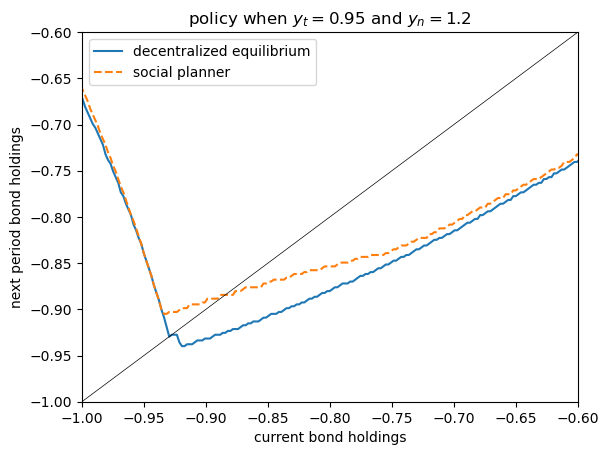

In [31]:
i, j = 1, 3
y_t, y_n = y_t_nodes[i], y_n_nodes[j]
fig, ax = plt.subplots()
ax.plot(b_grid, b_grid[H_eq[:, i, j]], label='decentralized equilibrium')
ax.plot(b_grid, b_grid[H_plan[:, i, j]], ls='--', label='social planner')
ax.plot(b_grid, b_grid, color='black', lw=0.5)
ax.set_ylim((-1.0, -0.6))
ax.set_xlim((-1.0, -0.6))
ax.set_xlabel("current bond holdings")
ax.set_ylabel("next period bond holdings")
ax.set_title(f"policy when $y_t = {y_t:.2}$ and $y_n = {y_n:.2}$")
ax.legend()
plt.show()

The match is not exact because we use a different estimate of the Markov
dynamics for income.

Nonetheless, it is qualitatively similar.

## Exercise

Your task is to examine the ergodic distribution of borrowing in the decentralized and
planner equilibria.

We recommend that you use simulation and a kernel density estimate.

Here's a function for generating the borrowing sequence.

We use Numba because we want to compile a long for loop.

In [32]:
@numba.jit
def generate_borrowing_sequence(H, y_t_series, y_n_series):
    """
    Generate the borrowing sequence B' = H(B, y_t, y_n).

    * H is a policy array
    * y_t_series and y_n_series are simulated time paths 

    Both y_t_series and y_n_series are stored as indices rather than values.

    """
    B = np.empty_like(y_t_series)
    B[0] = 0
    for t in range(len(y_t_series)-1):
        B[t+1] = H[B[t], y_t_series[t], y_n_series[t]]
    return B

Note that you will have to convert JAX arrays into NumPy arrays if you want to use this function.

From here you will need to 

* generate a time path for income $y = (y_t, y_n)$ using one of the functions provided above.
* use the function `generate_borrowing_sequence` plus `H_eq` and `H_plan` to calculate bond holdings for the planner and the decentralized equilibrium
* produce a kernel density plot for each of these data sets

If you are successful, your plot should look something like Fig 2 of Bianchi (2011) --- although not exactly the same, due to the alternative specification of the Markov process.

To generate a kernel density plot, we recommend that you use `kdeplot` from the package `seaborn`, which is included in Anaconda.

In [33]:
for i in range(18):
    print("Solution below.")

Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.


In [34]:
import seaborn  # For kernel density plots

In [35]:
sim_length = 100_000
y_t_series, y_n_series = generate_discrete_var(ts_length=sim_length,
                                               indices=True)

We convert JAX arrays to NumPy arrays in order to use Numba.

In [36]:
y_t_series, y_n_series, H_eq, H_plan = \
        [np.array(v) for v in (y_t_series, y_n_series, H_eq, H_plan)]

Now let's compute borrowing for the decentralized equilibrium and the planner.

In [37]:
B_eq = generate_borrowing_sequence(H_eq, y_t_series, y_n_series)
eq_b_sequence = b_grid[B_eq]
B_plan = generate_borrowing_sequence(H_plan, y_t_series, y_n_series)
plan_b_sequence = b_grid[B_plan]

We suppress some annoying warnings produced by the current version of `seaborn`

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Now let's plot the distributions using a kernel density estimator.

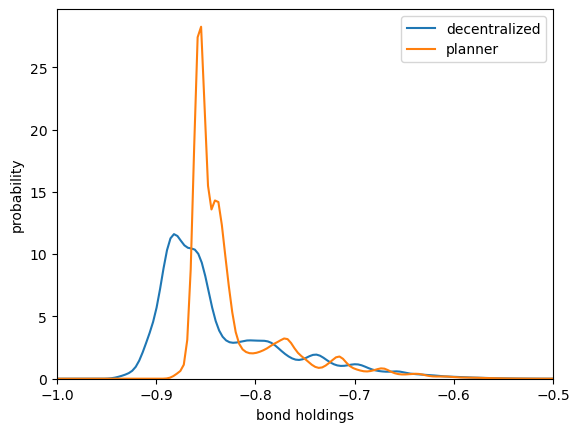

In [39]:
fig, ax = plt.subplots()
seaborn.kdeplot(eq_b_sequence, ax=ax, label='decentralized')
seaborn.kdeplot(plan_b_sequence, ax=ax, label='planner')
ax.legend()
ax.set_xlim((-1, -0.5))
ax.set_xlabel("bond holdings")
ax.set_ylabel("probability")
plt.show()

This corresponds to Figure 2 in Bianchi.

Again, the match is not exact but it is qualitatively similar.

Asset holding has a longer left hand tail under the decentralized equilibrium,
leaving the economy more vulnerable to bad shocks.